In [1]:

import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:

# Load your gesture dataset
import pandas as pd
from collections import defaultdict

df = pd.read_csv(r"C:\Users\RS10\Documents\Python\Master Inge\Machine learning\Projet\Standardize.csv")  # Read with header

# Remove rows where header might be repeated as data
df = df[df['x'] != 'x']

# Convert necessary columns to numeric
df[['x', 'y', 'z', 'time']] = df[['x', 'y', 'z', 'time']].astype(float)
df['gesture'] = df['gesture'].astype(int)

# Group by user, gesture, sequence
grouped = df.groupby(['user', 'gesture', 'sequence'])
sequences = defaultdict(list)

for (user, gesture, sequence), group in grouped:
    seq = group.sort_values(by='time')[['x', 'y', 'z', 'time']].to_numpy()
    sequences[(user, gesture)].append(seq)


In [3]:

def preprocess_sequences(sequence_list, max_len=None, scaler=None, fit_scaler=True):
    X, y = [], []
    for gesture_id, seqs in sequence_list:
        for seq in seqs:
            original_len = seq.shape[0]
            original_indices = np.linspace(0, 1, original_len)
            target_indices = np.linspace(0, 1, max_len)

            interpolated_features = [
                np.interp(target_indices, original_indices, seq[:, col].astype(float))
                for col in range(4)
            ]
            interpolated_seq = np.stack(interpolated_features, axis=1)
            X.append(interpolated_seq)
            y.append(gesture_id)

    X = np.array(X)
    if fit_scaler:
        scaler = StandardScaler()
        X = scaler.fit_transform(X.reshape(-1, 4)).reshape(X.shape)
    else:
        X = scaler.transform(X.reshape(-1, 4)).reshape(X.shape)

    y = to_categorical(np.array(y), num_classes=10)
    return X, y, scaler


In [4]:
from tensorflow.keras import Input

def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))    # <- use function parameter, not max_len
    model.add(Masking(mask_value=0.))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_user_independent(sequences):
    users = sorted(set(u for u, _ in sequences))
    accuracies = []
    all_y_true, all_y_pred = [], []

    for test_user in tqdm(users, desc="User-Independent Evaluation"):
        train_seqs = [((g), s) for (u, g), s in sequences.items() if u != test_user]
        test_seqs  = [((g), s) for (u, g), s in sequences.items() if u == test_user]

        max_len = max(seq.shape[0] for _, seqs in train_seqs + test_seqs for seq in seqs)
        X_train, y_train, scaler = preprocess_sequences(train_seqs, max_len=max_len, fit_scaler=True)
        X_test, y_test, _ = preprocess_sequences(test_seqs, max_len=max_len, scaler=scaler, fit_scaler=False)

        model = build_model((max_len, 4))
        model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)


        acc = accuracy_score(y_true_classes, y_pred_classes)
        accuracies.append(acc)
        all_y_true.extend(y_true_classes)
        all_y_pred.extend(y_pred_classes)

    print("User-Independent Accuracy: {:.2f}% ± {:.2f}".format(100 * np.mean(accuracies), 100 * np.std(accuracies)))

    # Confusion Matrix
    labels = sorted(set(all_y_true + all_y_pred))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix (User-Independent Evaluation)")
    plt.show()

    return accuracies


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_user_dependent(sequences):
    users = sorted(set(u for u, _ in sequences))
    accuracies = []
    all_y_true, all_y_pred = [], []

    for user in tqdm(users, desc="User-Dependent Evaluation"):
        user_seqs = {k: v for k, v in sequences.items() if k[0] == user}
        if not all(len(v) >= 10 for v in user_seqs.values()):
            continue

        for i in range(10):
            train_data, test_data = [], []
            for (u, g), seq_list in user_seqs.items():
                test_data.append((g, [seq_list[i]]))
                train_data.append((g, [s for j, s in enumerate(seq_list) if j != i]))

            max_len = max(seq.shape[0] for _, seqs in train_data + test_data for seq in seqs)
            X_train, y_train, scaler = preprocess_sequences(train_data, max_len=max_len, fit_scaler=True)
            X_test, y_test, _ = preprocess_sequences(test_data, max_len=max_len, scaler=scaler, fit_scaler=False)

            model = build_model((max_len, 4))
            model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

            y_pred = model.predict(X_test, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true_classes = np.argmax(y_test, axis=1)

            acc = accuracy_score(y_true_classes, y_pred_classes)
            accuracies.append(acc)
            all_y_true.extend(y_true_classes)
            all_y_pred.extend(y_pred_classes)

    print("User-Dependent Accuracy: {:.2f}% ± {:.2f}".format(100 * np.mean(accuracies), 100 * np.std(accuracies)))

    # Confusion Matrix
    labels = sorted(set(all_y_true + all_y_pred))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Oranges")
    plt.title("Confusion Matrix (User-Dependent Evaluation)")
    plt.show()

    return accuracies

User-Independent Evaluation: 100%|██████████| 10/10 [18:42<00:00, 112.27s/it]


User-Independent Accuracy: 50.60% ± 16.87


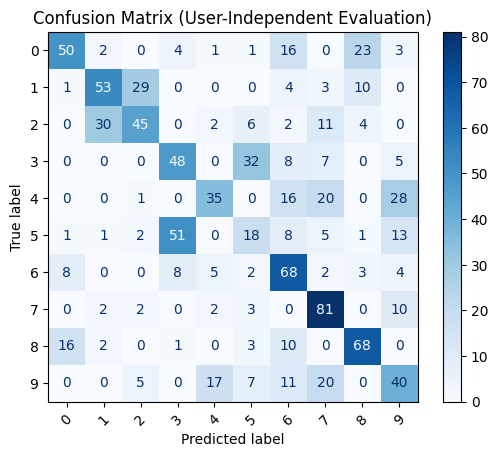

[0.55, 0.28, 0.73, 0.43, 0.57, 0.62, 0.34, 0.69, 0.63, 0.22]

In [11]:
evaluate_user_independent(sequences)

User-Dependent Evaluation: 100%|██████████| 10/10 [10:23<00:00, 62.38s/it]

User-Dependent Accuracy: 84.60% ± 11.70


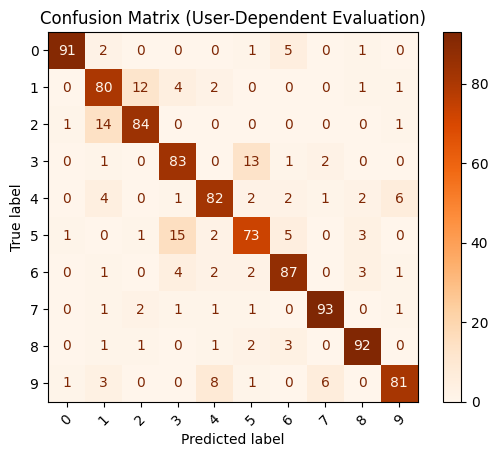

[0.8,
 0.8,
 0.8,
 0.7,
 0.7,
 0.9,
 0.9,
 1.0,
 0.8,
 0.8,
 0.8,
 0.6,
 0.8,
 0.9,
 0.9,
 0.8,
 1.0,
 0.7,
 0.7,
 0.8,
 0.6,
 1.0,
 0.9,
 0.9,
 0.9,
 1.0,
 0.7,
 0.9,
 0.9,
 0.9,
 0.7,
 0.8,
 0.9,
 1.0,
 1.0,
 0.8,
 1.0,
 0.9,
 0.8,
 0.8,
 0.5,
 1.0,
 1.0,
 0.9,
 0.9,
 0.9,
 0.8,
 0.7,
 1.0,
 0.6,
 0.7,
 0.9,
 0.8,
 0.7,
 0.9,
 0.8,
 1.0,
 0.8,
 0.7,
 0.8,
 0.8,
 1.0,
 0.7,
 0.9,
 0.9,
 0.9,
 0.9,
 0.8,
 0.9,
 1.0,
 0.9,
 0.8,
 0.8,
 1.0,
 1.0,
 0.8,
 1.0,
 0.9,
 0.8,
 0.9,
 0.6,
 0.8,
 1.0,
 0.9,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.7,
 0.6,
 0.9,
 0.7,
 0.9,
 0.8,
 0.8,
 0.9,
 0.9,
 0.9,
 0.7]

In [9]:
evaluate_user_dependent(sequences)